# Denoising Diffusion Probabilistic Models (DDPM)

As you saw, the [previous example](./01-vae.ipynb), VAE, was a one-step generation. Now we proceed to more robust generative models.<br>
In this notebook, we start to explore **diffusion models** by seeing one of famous denoising diffusion models, Denoising Diffusion Probabilistic Models (DDPM). Diffusion models perform data generation as a gradual refinement process, which made them more stable and easier to train.

DDPM applies incremental updates (chain of conversions) in encoder-decoder architecture, in which the sequence of encoder steps is called forward process and the sequence of decoder steps is called reverse process. (See [[Ho et al., 2020](https://arxiv.org/pdf/2006.11239)] for original paper. DDPM is inspired by the earlier work, [[Sohl-Dickstein et al., 2015](https://arxiv.org/pdf/1503.03585)], in which constructing a chain of conversions is proposed, instead of a one-step process.)<br>
In VAE, we have converted into the latent space (which has more small and concise dimensions) in encoding step. In DDPM, however, we'll make noise (i.e, noising) in forward process and remove noise (i.e, denoising) in reverse process.

![Noising and denoising](./assets/ddpm.png)

*From : "[Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239)"*

Our goal is to make appropriate reverse process in order for generating images by denoising.

*(back to [index](https://github.com/tsmatz/diffusion-tutorials/))*

## Architecture & Method

Let's briefly follow theoretical aspects behind denoising diffusion probabilistic model (DDPM) along with the original paper [[Ho et al., 2020](https://arxiv.org/pdf/2006.11239)].

Firstly, each incremental update in DDPM constructs a probabilistic Markov chain. (See below.)<br>
This architecture is also called variational diffusion models.

![DDPM grand architecture](./assets/ddpm_architecture.png)

In this structure, the starting point $\mathbf{x}_0$ is the original image (without noise).

It has 2 paths - one is called **forward process** and another is **reverse process**. (See above.)<br>
The forward process is realized as a chain on noising step. Each step in forward process adds a Gaussian noise by applying $q(\mathbf{x}_t|\mathbf{x}_{t-1})$.<br>
As you saw in [VAE example](./01-vae.ipynb), the next state $\mathbf{x}_t$ is then stochastically given by $p(\mathbf{x}_t) = p(\mathbf{x}_{t-1}) q(\mathbf{x}_t|\mathbf{x}_{t-1})$.<br>
On contrary, the reverse process is realized as a chain on denoising step. Each step in reverse process denoises by applying $p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)$, where $\theta$ is trainable parameters.<br>
Same as above, the denoised image in each step is also given by $p(\mathbf{x}_{t-1}) = p(\mathbf{x}_t) p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)$.

> Note : It's worth noting that $p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)$ is a single neural network (or a function) for all $t=1,2,\ldots,T$.

Also, same as in [VAE](./01-vae.ipynb), the final state $\mathbf{x}_T$ is assumed to be $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

### 1. Define forward process $q(\mathbf{x}_t|\mathbf{x}_{t-1})$ for adding Gaussian noise

In order to add a noise in forward process, we apply the following conditional distribution (which depends on the previous state $\mathbf{x}_{t-1}$).<br>
Unlike [VAE](./01-vae.ipynb), this distribution adding a noise, $q(\mathbf{x}_t|\mathbf{x}_{t-1})$, has no learnable parameters.

$\displaystyle q(\mathbf{x}_t|\mathbf{x}_{t-1}) \stackrel{\mathrm{def}}{=} \mathcal{N}(\mathbf{x}_t|\sqrt{\alpha_t}\mathbf{x}_{t-1},(1-\alpha_t)\mathbf{I}) \;\;\;\;\;\; (1)$

where $\alpha_t$ ($t=1,2,\ldots,T$) is a constant (depending on step $t$) which satisfies $0 < \alpha_t < 1$.

You might think that how this formula is derived ?<br>
The reason is that :<br>
In order to vanish into $\mathcal{N}(\mathbf{0}, \mathbf{I})$, first we define the conditional distibution $q_{\phi}(\mathbf{x}_t|\mathbf{x}_{t-1})$ as follows with the scaling factor $\sqrt{\alpha_t}$.

$q_{\phi}(\mathbf{x}_t|\mathbf{x}_{t-1})= \mathcal{N}(\mathbf{x}_t|\sqrt{\alpha_t}\mathbf{x}_{t-1},\sigma^2\mathbf{I})$

In this assumption, it's known that $\sigma^2$ should hold $\sigma^2 = 1-\alpha_t$ to vanish into $\mathbf{x}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ when $t \to \infty$. (In other words, if $\sigma^2 \neq 1-\alpha_t$, then $\mathbf{x}_t \not\sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \;\;\; (t \to \infty)$.)<br>
This is the reason why the equation (1) is formulated.

By equation (1), it's worth noting that $\mathbf{x}_t$ is written as follows by using $\epsilon \in \mathcal{N}(\mathbf{0}, \mathbf{I})$. :

$\displaystyle \mathbf{x}_t = \sqrt{\alpha_t} \mathbf{x}_{t-1} + \sqrt{1 - \alpha_t} \epsilon$

When the scaling factor $\sqrt{\alpha_t}$ is close to 0, the distribution immediately goes to $\mathcal{N}(\mathbf{0}, \mathbf{I})$. (On contrary, when the scaling factor $\sqrt{\alpha_t}$ is close to 1, it keeps the current distribution.)

Under these assumptions, it's known that the conditional distribution $q(\mathbf{x_t}|\mathbf{x_0})$ is given by :

$\displaystyle q(\mathbf{x_t}|\mathbf{x_0}) = \mathcal{N}(\mathbf{x_t}|\sqrt{\overline{\alpha}_t}\mathbf{x}_0, (1-\overline{\alpha}_t)\mathbf{I}) \;\;\;\;\;\; (2)$

where $\overline{\alpha}_t = \prod_{i=1}^t \alpha_i$

(Here I skip the proof of this equation.)

Thus, $\mathbf{x}_t$ is also written as follows using $\epsilon \in \mathcal{N}(\mathbf{0}, \mathbf{I})$.

$\displaystyle \mathbf{x}_t=\sqrt{\overline{\alpha}_t} \mathbf{x}_0 + \sqrt{1-\overline{\alpha}_t} \epsilon \;\;\;\;\;\; (3)$

### 2. Construct reverse process, $p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)$

Now it's turn of reverse process, $p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)$.<br>
Each step in reverse process should be counpled with each corresponding forward step.

To do this, firstly, let us consider how $q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)$ is formulated.<br>
Because Bayes theorem gives us $q(\mathbf{x}_{t-1}|\mathbf{x}_t)=\frac{q(\mathbf{x}_t|\mathbf{x}_{t-1})q(\mathbf{x}_{t-1})}{q(\mathbf{x}_t)}$, then

$\displaystyle q(\mathbf{x}_{t-1}|\mathbf{x}_t,\mathbf{x}_0)=\frac{q(\mathbf{x}_t|\mathbf{x}_{t-1}, \mathbf{x}_0)q(\mathbf{x}_{t-1}|\mathbf{x}_0)}{q(\mathbf{x}_t|\mathbf{x}_0)}$

Substituting (1) and (2) into each elements in right-hand side, we can obtain the following equation. :

$\displaystyle q(\mathbf{x}_{t-1}|\mathbf{x}_t,\mathbf{x}_0)=\mathcal{N}(\mathbf{x}_{t-1}|\tilde{\mu}_t(\mathbf{x}_t,\mathbf{x}_0),\tilde{\beta}_t\mathbf{I}) \;\;\;\;\;\; (4)$

where $\displaystyle \tilde{\mu}_t(\mathbf{x}_t,\mathbf{x}_0)=\frac{(1-\alpha_t)\sqrt{\overline{\alpha}_{t-1}}}{1-\overline{\alpha}_t} \mathbf{x}_0 + \frac{(1-\overline{\alpha}_{t-1})\sqrt{\alpha_t}}{1-\overline{\alpha}_t} \mathbf{x}_t$ and $\displaystyle \tilde{\beta}_t=\frac{(1-\alpha_t)(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_t}$

Thus, we now define $p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)$ as follows. :

$\displaystyle p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t) \stackrel{\mathrm{def}}{=} \mathcal{N}(\mathbf{x}_{t-1}|\mu_{\theta}(\mathbf{x}_t, t),\sigma_t^2 \mathbf{I}))$

where $\mu_{\theta}(\mathbf{x}_t, t)$ is a neural network (or a function) parameterized by $\theta$ and $\displaystyle \sigma_t^2 = \frac{(1-\alpha_t)(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_t}$.

It's worth noting that the output of $\mu_{\theta}(\mathbf{x}_t, t)$ depends on not only $\mathbf{x}_t$, but also step $t$. (In the implementation, we can then realize the neural network $p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)$ by applying timestep embedding.)

For this neural network, **U-Net** model with attention block is used in official repository implementation. (Later I'll show you details about this architecture.)

### 3. Optimization of $\theta$ (Optimization on variational bound)

As we saw in [VAE example](./01-vae.ipynb), let's think about optimization of $\theta$ by maximizing $\log p_{\theta}(\mathbf{x}_0)$. (i.e, minimizing the negative log likelihood $-\log p_{\theta}(\mathbf{x}_0)$ as a loss)

Firstly, because $\displaystyle \log p_{\theta}(\mathbf{x}_0) = \log \int p_{\theta}(\mathbf{x}_{0:T}) d \mathbf{x}_{1:T}$ (marginal probability), the expectation of $-\log p_{\theta}(\mathbf{x}_0)$ is :

$\displaystyle \mathbb{E}[-\log p_{\theta}(\mathbf{x}_0)] = \log \mathbb{E}_{q(\mathbf{x}_{1:T}|\mathbf{x}_0)} \left[ -\frac{p_{\theta}(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}|\mathbf{x}_0)} \right]$

Jensen’s inequality says that when $\varphi(\cdot)$ is concave, then $\varphi(\mathbb{E}[X]) \geq \mathbb{E}[\varphi(X)]$.<br>
By applying this, we now get :

$\displaystyle \mathbb{E}[-\log p_{\theta}(\mathbf{x}_0)] \leq \mathbb{E}_{q(\mathbf{x}_{1:T}|\mathbf{x}_0)} \left[ -\log \frac{p_{\theta}(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}|\mathbf{x}_0)} \right]$

By applying the conversion of Appendix A in [original paper](https://arxiv.org/pdf/2006.11239), we get :

$\displaystyle \mathbb{E}[-\log p_{\theta}(\mathbf{x}_0)] \leq \mathbb{E}_{q(\mathbf{x}_{1:T}|\mathbf{x}_0)} \left[ -\log \frac{p_{\theta}(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}|\mathbf{x}_0)} \right]$

$\displaystyle = D_{KL}(q(\mathbf{x}_T|\mathbf{x}_0)\|p(\mathbf{x}_T)) + \sum_{t>1} \mathbb{E}_{q(\mathbf{x}_t|\mathbf{x}_0)} \left[ D_{KL}(q(\mathbf{x}_{t-1}|\mathbf{x}_t,\mathbf{x}_0)\|p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)) \right] - \mathbb{E}_{q(\mathbf{x}_1|\mathbf{x}_0)} \left[ \log p_{\theta}(\mathbf{x}_0|\mathbf{x}_1) \right] \;\;\;\;\;\; (5)$

This equation (5) represents evidence lower bound (ELBO) in this problem.

For the first term $D_{KL}(q(\mathbf{x}_T|\mathbf{x}_0)\|p(\mathbf{x}_T))$, we can ignore this term, because we don't have any learnable parameters in $q(\mathbf{x}_T|\mathbf{x}_0)$ and we have set $\alpha_t$ (a constant) to become $\mathbf{x}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) (=p(\mathbf{x}_T))$ when $t \to \infty$. (See above.)

For the second term, both denominator and numerator are known Gaussian distribution (see above (4)), and we can then compute and get by :

$\displaystyle \mathbb{E}_{q(\mathbf{x}_t|\mathbf{x}_0)} \left[ D_{KL}(q(\mathbf{x}_{t-1}|\mathbf{x}_t,\mathbf{x}_0)\|p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)) \right] = \mathbb{E}_{q(\mathbf{x}_t|\mathbf{x}_0)} \left[ \frac{1}{2 \sigma_t^2} \| \tilde{\mu}_t(\mathbf{x}_t,\mathbf{x}_0) - \mu_{\theta}(\mathbf{x}_t, t) \|^2 \right] + C$

where $C$ is a constant.

> Note : In this equation, $\tilde{\mu}_t(\mathbf{x}_t,\mathbf{x}_0)$ comes from the forward process $q()$. (See above equation (4).)<br>
> And, $\mu_{\theta}(\mathbf{x}_t, t)$ and $\sigma_t^2$ comes from the reverse process $p_{\theta}()$.

It implies that the optimization of $\mu_{\theta}$ in the second term of (5) is to predict the mean of the forward process, i.e, $\tilde{\mu}_t(\mathbf{x}_t,\mathbf{x}_0)$.

For the third term, we can get as follows, by the definition of $p_{\theta}()$. (See above.) :

$\displaystyle \mathbb{E}_{q(\mathbf{x}_1|\mathbf{x}_0)}[\log p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)] = -\mathbb{E}_{q(\mathbf{x}_1|\mathbf{x}_0)}\left[\frac{\| \mathbf{x}_0 - \mu_{\theta}(\mathbf{x}_1, 1) \|^2}{2 \sigma_1^2} + \frac{d}{2} \log (2\pi\sigma_1^2)\right] $

where $d$ is the number of dimension.

It implies that the optimization of $\mu_{\theta}$ in the third term of (5) is to predict the original image $\mathbf{x}_0$.<br>
When we assume $\overline{\alpha}_0=1$, then it's also equivalent to predicting $\tilde{\mu}_1(\mathbf{x}_1,\mathbf{x}_0) = \mathbf{x}_0$.

This is a beauty of DDPM, because all we have to do in optimization is to minimize total loss between the sampling $\tilde{\mu}_t(\mathbf{x}_t,\mathbf{x}_0)$ and $\mu_{\theta}(\mathbf{x}_t, t)$ (with a weight $\frac{1}{2 \sigma_t^2}$) for all $\mathbf{x}_t$ ($t=1,2,\ldots,T$).

![optimize DDPM](./assets/ddpm_optimize.png)

### 4. Reparameterization for denoising

In above optimization, we should predict the mean in all steps, i.e, $\mu_{\theta}(\mathbf{x}_t, t)$ ($t=1,2,\ldots,T$).<br>
By applying reparameterization, finally we convert to predict the noise $\epsilon_{\theta}(\mathbf{x}_t, t)$ instead. (This is the reason why it's called "denoising" diffusion probability model !)

> Note : Because $q(\mathbf{x}_t|\mathbf{x}_0)$ doesn't have any learnable parameters, you don't then need to apply reparameterization to make the optimization enable. (You can apply gradient methods without reparameterization for optimizing $\mu_{\theta}(\mathbf{x}_t, t)$.)<br>
> By applying this reparameterization, however, the algorithm is so much simplified.

To do this, we consider to represent $\tilde{\mu}_t(\mathbf{x}_t,\mathbf{x}_0)$ (which is a mean on step $t-1$) using $\mathbf{x}_t$ and $\epsilon$ (a noise).

Recall the equation (3), and we then have :

$\displaystyle \mathbf{x}_0=\frac{\mathbf{x}_t - \sqrt{1-\overline{\alpha}_t}\epsilon}{\sqrt{\overline{\alpha}_t}}$

So, $\tilde{\mu}_t(\mathbf{x}_t,\mathbf{x}_0)$ can be written as :

$\displaystyle \tilde{\mu}_t(\mathbf{x}_t,\mathbf{x}_0)$

$\displaystyle =\frac{(1-\alpha_t)\sqrt{\overline{\alpha}_{t-1}}}{1-\overline{\alpha}_t} \mathbf{x}_0 + \frac{(1-\overline{\alpha}_{t-1})\sqrt{\alpha_t}}{1-\overline{\alpha}_t} \mathbf{x}_t$

$\displaystyle =\frac{(1-\alpha_t)\sqrt{\overline{\alpha}_{t-1}}}{1-\overline{\alpha}_t} \left( \frac{\mathbf{x}_t - \sqrt{1-\overline{\alpha}_t}\epsilon}{\sqrt{\overline{\alpha}_t}} \right) + \frac{(1-\overline{\alpha}_{t-1})\sqrt{\alpha_t}}{1-\overline{\alpha}_t} \mathbf{x}_t$

$\displaystyle =\frac{1}{\sqrt{\alpha}_t} \left( \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon \right)$

Now we then define a neural network (or a function) $\epsilon_{\theta}(\mathbf{x}_t, t)$ as follows, in which the output depends on the sampling $\mathbf{x}_t$ (generated in forward process) and also step $t$.

$\displaystyle \mu_{\theta}(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha}_t} \left( \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_{\theta}(\mathbf{x}_t, t) \right) $

> Note : To tell $\epsilon_{\theta}()$ that $\mathbf{x}_t$ is generated in which step, we should also provide $t$ as an input.

The following is the final optimization procedure by sampling.

1. Initialize $T$ and $\alpha_t$ ($t=1,\ldots,T$)
2. Pick up $\mathbf{x}_0$ in training set.
3. Pick up timestep $t$, such as $t \sim \verb|Uniform|(\{1,\ldots,T\})$
4. Generate the seed of noise $\epsilon$, such as $\epsilon \sim \mathcal{N}(\mathbf{0},\mathbf{I})$
5. Compute $\mathbf{x}_t = \sqrt{\overline{\alpha}_t}\mathbf{x}_0 + \sqrt{1-\overline{\alpha}_t}\epsilon$
6. Take the gradient descent step on $\nabla_{\theta} \| \epsilon - \epsilon_{\theta}(\mathbf{x}_t, t) \|^2$
7. Repeat 2 - 6 until convergence

Once it's trained (optimized), you can sequentially predict noise $\epsilon_{\theta}(\mathbf{x}_t, t)$ and denoised image $\mathbf{x}_t$ as follows.

1. Pick up white noise $\mathbf{x}_T$, such as, $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0},\mathbf{I})$
2. Loop the below procedure for $t=T,\ldots,1$
    - Pick up $\mathbf{z}$, such as, $\mathbf{z} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$ when $t>1$, $\mathbf{z} = \mathbf{0}$ otherwise
    - $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}} \epsilon_{\theta}(\mathbf{x}_t,t) \right) + \sigma_t \mathbf{z}$

The obtained (generated) $\mathbf{x}_0$ will become the final image without noise.

<blockquote>
Note : Here I don't go so far, but the subsequent work, <b>Latent Diffusion Model</b>, is an improved version of diffusion models, having a mixed architecture of VAE and diffusion.<br>
By encoding the representation in pixel space, the diffusion process can be performed in the low-dimensional latent space, not in pixel space. In this architecture, the VAE encoder $\mathcal{E}$ encodes a pixel image into a latent representation (semantic representation), and decoder $\mathcal{D}$ reconstructs a pixel image from a latent representation.<br>
It enables us high-resolution image synthesis, because it performs in low-dimensional latent space and reduces overhead.

![Latent Diffusion Model](./assets/latent_diffusion.png)

*From : "[High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752)"*

In Latent Diffusion Models, vision network (such like, U-Net) is not necessarily used as a denoising model, and Transformer-based model can also be used as a denoising model. (See [Diffusion Transformer](https://arxiv.org/pdf/2212.09748), shortly DiT.)<br>
Stable Diffusion and DALL-E are scalable versions of Latent Diffusion Models.
</blockquote>

## Build and Train model

Now let's see the code (implementation) step-by-step with description of theoretical aspect.

Before we start, we need to install the required packages.

In [ ]:
!pip install torch torchvision numpy matplotlib tqdm

### 1. Load data

We load images (CIFAR-10) dataset and dataloader.<br>
Each batch has shape ```[batch_size, 3, 32 32]```.

In [1]:
import torch
from torchvision import datasets, transforms

batch_size = 128

dataset = datasets.CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


Now I show 100 examples.

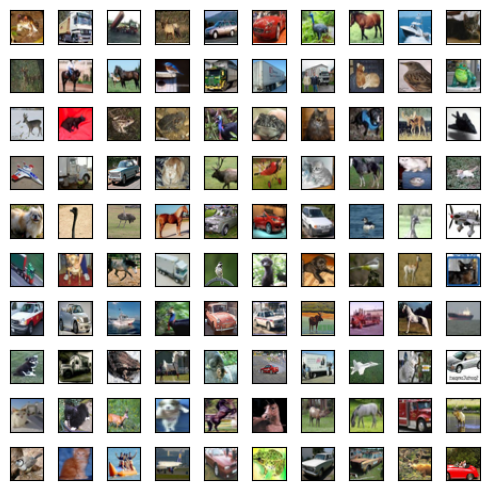

In [2]:
import numpy as np
import matplotlib.pyplot as plt

"""
for _, (data, _) in enumerate(loader):
    images = data[:3]
    break
for i in images:
    channel_last = np.transpose(i.numpy(), (1, 2, 0)) # (C, H, W) --> (H, W, C)
    plt.figure(figsize = (0.4,0.4))
    plt.imshow(channel_last)
    plt.show()
"""
num_row = 10
num_col = 10
fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
tmp_loader = torch.utils.data.DataLoader(dataset, batch_size=num_row*num_col, shuffle=False)
for data, _ in tmp_loader:
    for i in range(num_row*num_col):
        image = data[i].numpy()
        channel_last = np.transpose(image, (1, 2, 0)) # (C, H, W) --> (H, W, C)
        row = i//num_col
        col = i%num_col
        ax = axes[row, col]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(channel_last)
    break
plt.tight_layout()
plt.show()
del tmp_loader

### 2. Build $\epsilon_{\theta}$ (U-Net)

Now we build $\epsilon_{\theta}$ (which predicts the noise and is used for denoising) in the reverse process.

As we saw above, the output of $\epsilon_{\theta}(\mathbf{x}_t, t)$ depends on the step $t$, and we should then realize the neural network by applying timestep embedding.<br>
Before implementing $\epsilon_{\theta}$, firstly we create the network for this timestep embedding.

In the official implementation (see [here](https://github.com/hojonathanho/diffusion)), this is implemented by applying sinusoidal positional encoding + feedforward.<br>
Here I don't go so far about sinusoidal positional encoding, but please see [here](https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb) for implementation. (The sinusoidal encoding is used in the original paper of transformer "Attention Is All You Need".)

> Note : As you can see below, the output demension is always 128 * 4 in this network. However, when applying in the following blocks, the demension is changed to fit to each blocks by applying the additional feedforward network (linear network). (See the following ```ResnetBlock``` class implementation.)

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# For details about sinusoidal positional encoding in this implementation,
# see https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb
class PositionalEncoding(nn.Module):
    def __init__(
        self,
        base_dim, # 128
        hidden_dim, # 256
        output_dim, # 512
    ):
        super().__init__()

        # In this example, we assume that the number of embedding dimension is always even.
        # (If not, please pad the result.)
        assert(base_dim % 2 == 0)
        self.timestep_dim = base_dim

        self.hidden1 = nn.Linear(
            base_dim,
            hidden_dim)
        self.hidden2 = nn.Linear(
            hidden_dim,
            output_dim)

    def forward(self, picked_up_timesteps):
        """
        Generate timestep embedding vectors
    
        Parameters
        ----------
        picked_up_timesteps : torch.tensor((batch_size), dtype=int)
            Randomly picked up timesteps
    
        Returns
        ----------
        out : torch.tensor((batch_size, output_dim), dtype=float)
            Generated timestep embeddings (vectors) for each timesteps.
        """

        # Generate 1 / 10000^{2i / d_e}
        # shape : (timestep_dim / 2, )
        interval = 1.0 / (10000**(torch.arange(0, self.timestep_dim, 2.0).to(device) / self.timestep_dim))
        # Generate t / 10000^{2i / d_e}
        # shape : (batch_size, timestep_dim / 2)
        position = picked_up_timesteps.type(torch.get_default_dtype())
        radian = position[:, None] * interval[None, :]
        # Get sin(t / 10000^{2i / d_e}) and unsqueeze
        # shape : (batch_size, timestep_dim / 2, 1)
        sin = torch.sin(radian).unsqueeze(dim=-1)
        # Get cos(t / 10000^{2i / d_e}) and unsqueeze
        # shape : (batch_size, timestep_dim / 2, 1)
        cos = torch.cos(radian).unsqueeze(dim=-1)
        # Get sinusoidal positional encoding
        # shape : (batch_size, timestep_dim)
        pe_tmp = torch.concat((sin, cos), dim=-1)   # shape : (num_timestep, timestep_dim / 2, 2)
        d = pe_tmp.size()[1]
        pe = pe_tmp.view(-1, d * 2)                 # shape : (num_timestep, timestep_dim)
        # Apply feedforward
        # shape : (batch_size, timestep_dim * 4)
        out = self.hidden1(pe)
        out = F.silu(out)
        out = self.hidden2(out)

        return out

Now we build the network $\epsilon_{\theta}$.

In the official implementation (see [here](https://github.com/hojonathanho/diffusion)), it's built by **U-Net** model with attention blocks as follows. (See the following picture for architecture.)

![U-Net](./assets/unet.png)

> Note : As I have mentioned above, the timestep embedding is also fed into blocks as an input. It's not drawn in above picture.

This architecture consists of 2 main parts - top-to-down path (encoder, left-hand-side in above picture) and bottom-to-up path (decoder, right-hand-side in above picture).

In top-to-down path (encoder), each layer reduces the resolution of the input (32x32 --> 16x16 --> 8x8 --> 4x4), and it will be recovered in the bottom-to-up path (decoder).<br>
Each block mostly consists of resnet architecture (convolution + residual network), but same as in the official implementation, I have also added self-attention block (see [here](https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb)) with resnet block only in 16x16 feature map resolution.

> Note : See [here](https://arxiv.org/pdf/1712.09763) for details about residual block + attention block architecture in generative models.

The output of each layer in top-to-down path (encoder) is concatenated into the corresponding layer in bottom-to-up path (decoder).

For details about this architecture, see Appendix B in [original paper](https://arxiv.org/pdf/2006.11239).

> Note : You can use more improved architecture **DDPM++** from [[Song et. al., 2021](https://arxiv.org/pdf/2011.13456)]. (For more details, see Appendix H in this paper.)

> Note : Because the latent diffusion doesn't perform in pixel space (see above), the latest stable diffusion version 3 and above use fully Transformer-based architecture (**Diffusion Transformer**, shortly DiT), instead of using convolutional UNet backbone with self-attention in low resolutions. (See [[Peebles and Xie, 2023](https://arxiv.org/pdf/2212.09748)] and [[Esser et. al., 2024](https://arxiv.org/pdf/2403.03206)].)

First, I build each components (blocks) used in this network.

In [5]:
class ResnetBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        num_norm_groups, # 32
        timestep_embedding_dim, # 512
    ):
        super().__init__()

        # for normalization
        self.norm1 = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=in_channel,
            eps=1e-06,
        )
        self.norm2 = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=out_channel,
            eps=1e-06,
        )

        # for applying conv
        self.conv1 = nn.Conv2d(
            in_channel,
            out_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )
        self.conv2 = nn.Conv2d(
            out_channel,
            out_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )

        # for adding timestep
        self.linear_pos = nn.Linear(timestep_embedding_dim, out_channel)

        # for residual block
        if in_channel != out_channel:
            self.linear_src = nn.Linear(in_channel, out_channel)
        else:
            self.linear_src = None

    def forward(self, x, t_emb):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            input x
        t_emb : torch.tensor((batch_size, base_channel_dim * 4), dtype=float)
            timestep embeddings
        """

        # Apply conv
        out = self.norm1(x)
        out = F.silu(out)
        out = self.conv1(out)

        # Add timestep encoding
        pos = F.silu(t_emb)
        pos = self.linear_pos(pos)
        pos = pos[:, :, None, None]
        out = out + pos

        # apply dropout + conv
        out = self.norm2(out)
        out = F.silu(out)
        out = F.dropout(out, p=0.1, training=self.training)
        out = self.conv2(out)

        # apply residual
        if self.linear_src is not None:
            x_trans = x.permute(0, 2, 3, 1)       # (N,C,H,W) --> (N,H,W,C)
            x_trans = self.linear_src(x_trans)
            x_trans = x_trans.permute(0, 3, 1, 2) # (N,H,W,C) --> (N,C,H,W)
            out = out + x_trans
        else:
            out = out + x

        return out

#
# For the implementation of multi-head attention,
# see https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb
#
class AttentionBlock(nn.Module):
    def __init__(
        self,
        channel,
        num_norm_groups, # 32
    ):
        super().__init__()

        self.norm = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=channel,
            eps=1e-06,
        )

        self.q_layer = nn.Linear(channel, channel)
        self.k_layer = nn.Linear(channel, channel)
        self.v_layer = nn.Linear(channel, channel)

        self.output_linear = nn.Linear(channel, channel, bias=False)

    def forward(self, x):
        channel = x.size(dim=1)
        height = x.size(dim=2)
        width = x.size(dim=3)

        out = self.norm(x)

        # reshape : (N,C,H,W) --> (N,H*W,C)
        out = out.permute(0, 2, 3, 1)
        out = out.view(-1, height*width, channel)

        # generate query/key/value
        q = self.q_layer(out)
        k = self.k_layer(out)
        v = self.v_layer(out)

        # compute Q K^T
        score = torch.einsum("bic,bjc->bij", q, k)

        # scale the result by 1/sqrt(channel)
        score = score / channel**0.5

        # apply softtmax
        score = F.softmax(score, dim=-1)

        # apply dot product with values
        out = torch.einsum("bij,bjc->bic", score, v)

        # apply final linear
        out = self.output_linear(out)

        # reshape : (N,H*W,C) --> (N,C,H,W)
        out = out.view(-1, height, width, channel)
        out = out.permute(0, 3, 1, 2)

        # apply residual
        out = out + x

        return out

class ResnetAndAttention(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        num_norm_groups, # 32
        timestep_embedding_dim, # 512
    ):
        super().__init__()

        self.resnet = ResnetBlock(
            in_channel,
            out_channel,
            num_norm_groups,
            timestep_embedding_dim,
        )
        self.attention = AttentionBlock(
            out_channel,
            num_norm_groups,
        )

    def forward(self, x, t_emb):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            input x
        t_emb : torch.tensor((batch_size, base_channel_dim * 4), dtype=float)
            timestep embeddings
        """
        out = self.resnet(x, t_emb)
        out = self.attention(out)
        return out

# Resized into the shape (C,H/2,W/2)
# (This is equivalent to torch.nn.Conv2d.)
class DownSample(nn.Module):
    def __init__(
        self,
        channel,
    ):
        super().__init__()

        self.conv = nn.Conv2d(
            channel,
            channel,
            kernel_size=3,
            stride=2,
            padding=1,
        )

    def forward(self, x):
        return self.conv(x)

# Resized into the shape (C,H*2,W*2)
class UpSample(nn.Module):
    def __init__(
        self,
        channel,
    ):
        super().__init__()

        self.conv = nn.Conv2d(
            channel,
            channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )

    def forward(self, x):
        out = F.interpolate(x, scale_factor=2, mode="nearest")
        out = self.conv(out)
        return out

Using above components (blocks), now we build U-Net as follows.

In [6]:
class UNet(nn.Module):
    def __init__(
        self,
        source_channel, # 3
        unet_base_channel, # 128
        num_norm_groups, # 32
    ):
        super().__init__()

        self.pos_enc = PositionalEncoding(
            base_dim=unet_base_channel,
            hidden_dim=unet_base_channel*2,
            output_dim=unet_base_channel*4,
        )

        self.down_conv = nn.Conv2d(
            source_channel,
            unet_base_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )
        self.top_to_down = nn.ModuleList([
            # 1st layer
            ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            DownSample(
                channel=unet_base_channel,
            ),
            # 2nd layer
            ResnetAndAttention(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            DownSample(
                channel=unet_base_channel*2,
            ),
            # 3rd layer
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            DownSample(
                channel=unet_base_channel*2,
            ),
            # 4th layer
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
        ])
        self.middle = nn.ModuleList([
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            AttentionBlock(
                channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
        ])
        self.bottom_to_up = nn.ModuleList([
            # 1st layer
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            UpSample(
                channel=unet_base_channel*2,
            ),
            # 2nd layer
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            UpSample(
                channel=unet_base_channel*2,
            ),
            # 3rd layer
            ResnetAndAttention(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*3,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            UpSample(
                channel=unet_base_channel*2,
            ),
            # 4th layer
            ResnetBlock(
                in_channel=unet_base_channel*3,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                timestep_embedding_dim=unet_base_channel*4,
            ),
        ])
        self.norm = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=unet_base_channel,
            eps=1e-06,
        )
        self.up_conv = nn.Conv2d(
            unet_base_channel,
            source_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )

    def forward(self, x, t):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            Gaussian-noised images
        t : torch.tensor((batch_size), dtype=int)
            timestep
        """

        buffer = []

        # generate time embedding
        time_embs = self.pos_enc(t)

        #
        # Top-to-down
        #

        # apply down-convolution
        out = self.down_conv(x)
        buffer.append(out)
        # apply top-to-down
        for block in self.top_to_down:
            if isinstance(block, ResnetBlock):
                out = block(out, time_embs)
            elif isinstance(block, ResnetAndAttention):
                out = block(out, time_embs)
            elif isinstance(block, DownSample):
                out = block(out)
            else:
                raise Exception("Unknown block")
            buffer.append(out)

        #
        # Middle
        #
        for block in self.middle:
            if isinstance(block, ResnetBlock):
                out = block(out, time_embs)
            elif isinstance(block, AttentionBlock):
                out = block(out)
            else:
                raise Exception("Unknown block")

        #
        # Bottom-to-up
        #

        # apply bottom-to-up
        for block in self.bottom_to_up:
            if isinstance(block, ResnetBlock):
                buf = buffer.pop()
                out = torch.cat((out, buf), dim=1)
                out = block(out, time_embs)
            elif isinstance(block, ResnetAndAttention):
                buf = buffer.pop()
                out = torch.cat((out, buf), dim=1)
                out = block(out, time_embs)
            elif isinstance(block, UpSample):
                out = block(out)
            else:
                raise Exception("Unknown block")
        # apply up-convolution
        out = self.norm(out)
        out = F.silu(out)
        out = self.up_conv(out)

        assert not buffer

        return out

In [7]:
#
# Generate model
#
unet = UNet(
    source_channel=3,
    unet_base_channel=128,
    num_norm_groups=32,
).to(device)

### 3. Train (Optimize) $\epsilon_{\theta}$

Now let's train $\epsilon_{\theta}$ (i.e, above U-Net).

As we saw above, we can train $\epsilon_{\theta}$ by the following steps.

1. Initialize $T$ and $\alpha_t$ ($t=1,\ldots,T$)
2. Pick up $\mathbf{x}_0$ in training set.
3. Pick up timestep $t$, such as $t \sim \verb|Uniform|(\{1,\ldots,T\})$
4. Generate the seed of noise $\epsilon$, such as $\epsilon \sim \mathcal{N}(\mathbf{0},\mathbf{I})$
5. Compute $\mathbf{x}_t = \sqrt{\overline{\alpha}_t}\mathbf{x}_0 + \sqrt{1-\overline{\alpha}_t}\epsilon$
6. Take the gradient descent step on $\nabla_{\theta} \| \epsilon - \epsilon_{\theta}(\mathbf{x}_t, t) \|^2$
7. Repeat 2 - 6 until convergence

In this procedure, a large $T$ (such as, ```T=1000```) allows a reverse process to be close to a Gaussian (see [here](https://arxiv.org/pdf/1503.03585)), so that the generative process modeled with Gaussian conditional distributions leads to a good approximation.

In this example, I have directly configured $\alpha_t$ ($t=1,\ldots,T$) as fixed parameters, but please tune and configure $\beta_t = 1 - \alpha_t$ instead, which consists of a variance in each noising step.<br>
The paper says that $\beta_1=10^{-4}$ (i.e., $\alpha_1=0.9999$) and $\beta_T=0.02$ (i.e., $\alpha_T=0.98$) will give us better performance, and I have then configured the same setting.<br>
(See "Appendix B: Experimental details" in [original paper](https://arxiv.org/pdf/2006.11239).)

I note that each step number in the comment (below) is corresponding to above number.

> Note : Each $\alpha_t$ ($t=1,\ldots,T$) needs double precision in this example.<br>
> We then generate $\alpha_t$ as double precision and convert to a single precision in computing loss by applying ```float()```, in order to save GPU memory consumption.

> Note : I have stopped the training with 500 epochs, but please run more to get more high quality samples.<br>
> The training requires a few days to complete with a single GPU.

In [8]:
import os

# initialize optimizer
opt = torch.optim.Adam(unet.parameters(), lr=2e-4, eps=1e-08)
scheduler = torch.optim.lr_scheduler.LinearLR(
    opt,
    start_factor=1.0/5000,
    end_factor=1.0,
    total_iters=5000)

# 1. Initialize T and alpha
#   (See above note for precision.)
T = 1000
alphas = torch.linspace(start=0.9999, end=0.98, steps=T, dtype=torch.float64).to(device)
alpha_bars = torch.cumprod(alphas, dim=0)
sqrt_alpha_bars_t = torch.sqrt(alpha_bars)
sqrt_one_minus_alpha_bars_t = torch.sqrt(1.0 - alpha_bars)

# remove log file if exists
log_file = "train_loss.log"
if os.path.exists(log_file):
    os.remove(log_file)

# loop
num_epochs = 500
for epoch_idx in range(num_epochs):
    epoch_loss = []
    for batch_idx, (data, _) in enumerate(loader):
        unet.train()
        opt.zero_grad()

        # 2. Pick up x_0 (shape: [batch_size, 3, 32, 32])
        x_0 = data.to(device)

        # 3. Pick up random timestep, t .
        #    Instead of picking up t=1,2, ... ,T ,
        #    here we pick up t=0,1, ... ,T-1 .
        #   (i.e, t == 0 means diffused for 1 step)
        b = x_0.size(dim=0)
        t = torch.randint(T, (b,)).to(device)

        # 4. Generate the seed of noise, epsilon .
        #    We just pick up from 1D standard normal distribution with the same shape,
        #    because off-diagonal elements in covariance is all zero.
        eps = torch.randn_like(x_0).to(device)

        # 5. Compute x_t = sqrt(alpha_bar_t) x_0 + sqrt(1-alpha_bar_t) epsilon
        #    (t == 0 means diffused for 1 step)
        x_t = sqrt_alpha_bars_t[t][:,None,None,None].float() * x_0 + sqrt_one_minus_alpha_bars_t[t][:,None,None,None].float() * eps

        # 6. Get loss and apply gradient (update)
        model_out = unet(x_t, t)
        loss = F.mse_loss(model_out, eps, reduction="mean")
        loss.backward()
        opt.step()
        scheduler.step()

        # log
        epoch_loss.append(loss.item())
        print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, loss), end="\r")

    # finalize epoch (save log and checkpoint)
    epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, epoch_average_loss))
    with open(log_file, "a") as f:
        for l in epoch_loss:
            f.write("%s\n" %l)
    torch.save(unet.state_dict(), f"ddpm_unet_{epoch_idx}.pt")

print("Done")

epoch1 (iter391) - loss 0.3943
epoch2 (iter391) - loss 0.0659
epoch3 (iter391) - loss 0.0412
epoch4 (iter391) - loss 0.0325
epoch5 (iter391) - loss 0.0287
epoch6 (iter391) - loss 0.0260
epoch7 (iter391) - loss 0.0247
epoch8 (iter391) - loss 0.0232
epoch9 (iter391) - loss 0.0221
epoch10 (iter391) - loss 0.0214
epoch11 (iter391) - loss 0.0217
epoch12 (iter391) - loss 0.0206
epoch13 (iter391) - loss 0.0202
epoch14 (iter391) - loss 0.0200
epoch15 (iter391) - loss 0.0198
epoch16 (iter391) - loss 0.0197
epoch17 (iter391) - loss 0.0194
epoch18 (iter391) - loss 0.0195
epoch19 (iter391) - loss 0.0194
epoch20 (iter391) - loss 0.0189
epoch21 (iter391) - loss 0.0189
epoch22 (iter391) - loss 0.0186
epoch23 (iter391) - loss 0.0186
epoch24 (iter391) - loss 0.0188
epoch25 (iter391) - loss 0.0187
epoch26 (iter391) - loss 0.0186
epoch27 (iter391) - loss 0.0186
epoch28 (iter391) - loss 0.0180
epoch29 (iter391) - loss 0.0182
epoch30 (iter391) - loss 0.0181
epoch31 (iter391) - loss 0.0182
epoch32 (iter391)

Show loss transition of the first 10 epochs in training.

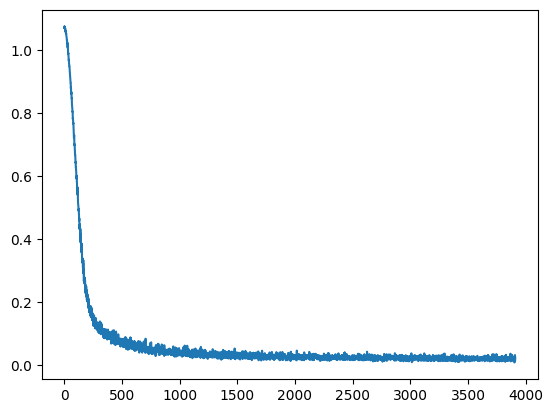

In [9]:
with open(log_file, "r") as f:
    all_loss = [float(line) for line in f]
num_rec = len(all_loss) * 10 // num_epochs
plt.plot(all_loss[:num_rec])

## Image generation with trained model

Now let's create images using above trained model (U-Net).

As I have mentioned above, the image is generated by the following procedure.

1. Pick up white noise $\mathbf{x}_T$, such as, $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0},\mathbf{I})$
2. Loop the below procedure for $t=T,\ldots,1$
    - Pick up $\mathbf{z}$, such as, $\mathbf{z} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$ when $t>1$, $\mathbf{z} = \mathbf{0}$ otherwise
    - $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}} \epsilon_{\theta}(\mathbf{x}_t,t) \right) + \sigma_t \mathbf{z}$ , where $\sigma_t^2 = \frac{(1-\alpha_t)(1-\overline{\alpha}_{t-1})}{1-\overline{\alpha}_t}$
3. The obtained (generated) $\mathbf{x}_0$ will become the final image without noise.

I note that each step number in the comment (below) is corresponding to above number.

> Note : As you could see here, the generation process in DDPM is very slow, because the reverse diffusion process needs a large number of denoising iterations.<br>
> [DDIM](https://arxiv.org/pdf/2010.02502) (Denoising Diffusion Implicit Models) is an invention to reduce the number of iterations required by the generative model, by transforming Markovian diffusion process to non-Markovian.

100%|████████████████████████████████████████████████████████████| 1000/1000 [03:57<00:00,  4.21it/s]


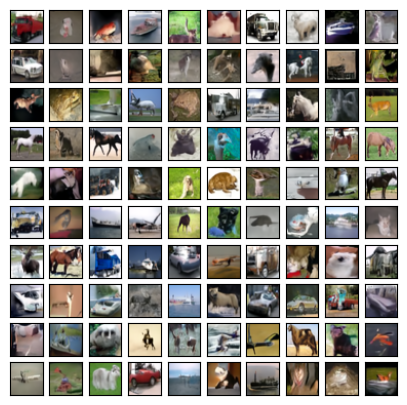

In [10]:
import tqdm

def run_inference(unet, num_images):
    unet.eval()
    # 0. generate sigma_t
    alpha_bars_prev = torch.cat((torch.ones(1).to(device), alpha_bars[:-1]))
    sigma_t_squared = (1.0 - alphas) * (1.0 - alpha_bars_prev) / (1.0 - alpha_bars)
    sigma_t = torch.sqrt(sigma_t_squared)
    # 1. make white noise
    x = torch.randn(num_images, 3, 32, 32).to(device)
    # 2. loop
    #   (t == 0 means diffused for 1 step)
    with torch.no_grad():
        for t in tqdm.tqdm(reversed(range(T)), total=T):
            if t > 0:
                z = torch.randn_like(x).to(device)
            else:
                z = torch.zeros_like(x).to(device)
            t_batch = (torch.tensor(t).to(device)).repeat(num_images)
            epsilon = unet(x, t_batch)
            x = (1.0 / torch.sqrt(alphas[t])).float() * (x - ((1.0 - alphas[t]) / torch.sqrt(1.0 - alpha_bars[t])).float() * epsilon) + \
                sigma_t[t].float() * z

    # reshape to channels-last : (N,C,H,W) --> (N,H,W,C)
    x = x.permute(0, 2, 3, 1)

    # clip
    x = torch.clamp(x, min=0.0, max=1.0)

    return x

# initialize
num_row = 10
num_col = 10
# generate images
x = run_inference(unet, num_row*num_col)
# draw
fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
for i in range(num_row*num_col):
    image = x[i].cpu().numpy()
    row = i//num_col
    col = i%num_col
    ax = axes[row, col]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image)